In [1]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=[4, 4])
plt.imshow(x_train[1], cmap='gray')
plt.colorbar()
plt.show()

<Figure size 400x400 with 2 Axes>

In [11]:
# declare functions

def non_linear(x, out_dim, h_dim, reuse=False):
    
    with tf.variable_scope('non_linear', reuse=reuse):
        x = tf.layers.dense(x, h_dim, activation=tf.nn.relu)        
        x = tf.layers.dense(x, h_dim, activation=tf.nn.relu)        
        x = tf.layers.dense(x, h_dim, activation=tf.nn.relu)        
        x = tf.layers.dense(x, h_dim, activation=tf.nn.relu)        
        x = tf.layers.dense(x, out_dim)
    
        return x

class CouplingLayer():
    def __init__(self, name, dim, h_dim):
        self.name = name
        self.dim = dim
        self.h_dim = h_dim
        
        # forward shuffle array
        self.indices = [i for i in range(self.dim)]
        np.random.shuffle(self.indices)
        
        # backward shuffle array
        self.inverse_indices = np.zeros(self.dim)
        for i in range(self.dim):
            self.inverse_indices[self.indices[i]] = i
            
    def forward(self, x, reuse=False):
        
        with tf.variable_scope(self.name, reuse=reuse):
            # x : [batch, dim]
            
            # shuffle
            # permutation matrix : [dim, dim]
            permutation_matrix = tf.one_hot(self.indices, self.dim, dtype=tf.float32)
            x_shape = tf.shape(x)
            x = tf.reshape(x, [-1, self.dim])
            x = x @ permutation_matrix
            x = tf.reshape(x, x_shape)
            
            # split
            a_dim = int(self.dim / 2)
            b_dim = self.dim - a_dim
            
            x_a = x[:, :a_dim]
            x_b = x[:, a_dim:]
            
            # non-linear layer
            m = non_linear(x_a, b_dim, self.h_dim, reuse=reuse)
            x_b += m
            
            # merge
            y = tf.concat([x_a, x_b], axis=-1)

            return y
    
    def backward(self, y, reuse=False):
        
        with tf.variable_scope(self.name, reuse=reuse):
            
            # split
            a_dim = int(self.dim / 2)
            b_dim = self.dim - a_dim
            
            y_a = y[:, :a_dim]
            y_b = y[:, a_dim:]
            
            # non-linear layer
            m = non_linear(y_a, b_dim, self.h_dim, reuse=reuse)
            y_b -= m
            
            # merge
            y = tf.concat([y_a, y_b], axis=-1)
            
            # shuffle
            # permutation matrix : [dim, dim]
            permutation_matrix = tf.one_hot(self.inverse_indices, self.dim, dtype=tf.float32)
            y_shape = tf.shape(y)
            y = tf.reshape(y, [-1, self.dim])
            y = y @ permutation_matrix
            y = tf.reshape(y, y_shape)
            
            return y


In [25]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()

# hyper-parameters
Batch = None
Height = 28
Width = 28
Dim = Height * Width
H_Dim = 1000
coupling_layers_num = 10
GAUSSIAN, LOGISTIC = 0, 1
prior = LOGISTIC

inputs = tf.placeholder(dtype=tf.float32, shape=[Batch, Height, Width])
noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=1./256.)
inputs_flattened = tf.layers.flatten(inputs + noise)

coupling_layers = [CouplingLayer('coupling_layer' + str(i), Dim, H_Dim) for i in range(coupling_layers_num)]

# Forward
h_forward = inputs_flattened
for coupling_layer in coupling_layers:
    h_forward = coupling_layer.forward(h_forward)
    
log_s = tf.get_variable('log_scale', shape=[Dim], dtype=tf.float32)
s = tf.exp(log_s)
z = h_forward * s


# calculate loss
# from https://github.com/laurent-dinh/nice/blob/master/pylearn2/models/nice.py

if prior == GAUSSIAN:
    log_likelihoods = tf.reduce_sum(-0.5 * (z ** 2 + np.log(2. * np.pi)), axis=1) + tf.reduce_sum(log_s)
else: # prior == LOGISTIC:
    log_likelihoods = tf.reduce_sum(-(tf.nn.softplus(z) + tf.nn.softplus(-z)), axis=1) + tf.reduce_sum(log_s)

loss = tf.reduce_mean(-log_likelihoods)


# Backward (sampling)

temperature = tf.get_variable('temperature', shape=(), dtype=tf.float32)
if prior == GAUSSIAN:
    z_sampled = tf.random.normal(shape=[100, Dim], stddev=temperature)
else: # prior == LOGISTIC:
    z_sampled = tf.contrib.distributions.Logistic(loc=0., scale=temperature).sample([100, Dim])
    
h_backward = z_sampled / s
for coupling_layer in reversed(coupling_layers):
    h_backward = coupling_layer.backward(h_backward, reuse=True)

x_sampled = tf.reshape(h_backward, [100, Height, Width])

# optimization
optim = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

# session create
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('graph created')

graph created


negative log-likelihood :  1829.6246


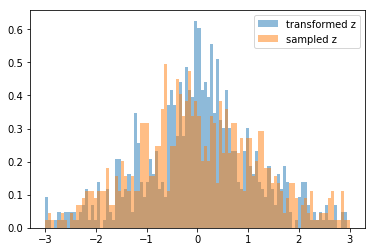

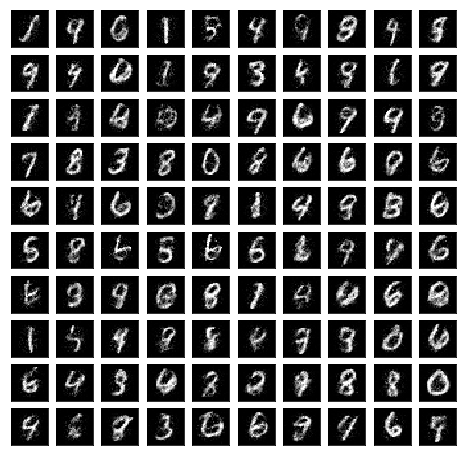

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import time

batch_size = 100

while(True):
    for _ in tqdm(range(1000)):
        indexes = np.random.randint(0, len(x_train), batch_size)
        _inputs = x_train[indexes]
        _, _loss, _z = sess.run([optim, loss, z], feed_dict={inputs: _inputs})
        
    clear_output()
    print('negative log-likelihood : ', -_loss)
    
    _z = _z[-1]
    
    _z_sampled, _x_sampled = sess.run([z_sampled, x_sampled], feed_dict={temperature: 0.8})
    _x_sampled = np.clip(_x_sampled, 0., 1.)
    _z_sampled = _z_sampled[-1]
    
    _, _, _z_handle = plt.hist(_z, bins=100, range=[-3., 3.], density=True, alpha=0.5, label='transformed z')
    _, _, _z_sampled_handle = plt.hist(_z_sampled, bins=100, range=[-3., 3.], density=True, alpha=0.5, label='sampled z')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=[8, 8])
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(_x_sampled[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()
        